In [3]:
#import pandas as pd
import warnings
'''
127.0.0.1:8000:/?token=417c65a720ebe817507356246b10f9a925d3b89cbb60ed50
'''

import numpy as np
import matplotlib.pyplot as plt
import random
import json
from sklearn.manifold import TSNE
import warnings
import seaborn as sbs
import seaborn_image as sbsi
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader

### changelog
- new model with more dimensions
- all classes remade
- in general more interaction with constructor

# Workflow

functions of the different classes:

1. generator:

    generate data sampled from gaussian distribution

    in: parameters

    out: [class, samples, features]
    

2. confounder_injection: confound generated data 

    create bias with different functions (atm "prior shift" can be used)
    
    in: [class, samples, features], parameters
    
    out [class, samples, features]


3. create_dataset:
    
    takes numpy array and parameters to create tensors, datasets and finally dataloaders (for input in pytorch models)

    in: [samples, features], split
    
    out: dataloaders
    

4. run_pytorch:
    
    trains and tests model with given dataloaders and parameters
    
    in: mode, dataloaders
    
    out: mean accuracy and loss
    

5. test_network
    in: params, number of rounds
    
    combines these functions for easier testing

# Plotting

In [4]:
warnings.filterwarnings("ignore",category=FutureWarning)

In [5]:
class plot:
    def __init__(self):
        pass

    def acc_loss(self, acc, loss):
        sbs.lineplot(y=acc, x=range(1,len(acc)+1))
        plt.title("Accuracy")
        plt.ylim(0,1.1)
        plt.xlim(1,len(acc))
        plt.show()
        print("With mean accuracy=",np.mean(acc))


    # plot distributions (includes all samples of the class)
    def tsne(self, x, y, n):
        x = np.reshape(x, (x.shape[0],-1))
        x_embedded = TSNE(random_state=42, n_components=n, learning_rate="auto", init="pca").fit_transform(x)
        print("t_SNE shape: ",x_embedded.shape)
        sbs.scatterplot(x=x_embedded[:,0], y=x_embedded[:,1], hue=y)
        plt.title("t-SNE")
        plt.ylabel("Probability")
        plt.xlabel("Value")
        plt.show()

    def image(self, x):
        plt.imshow(x[0,:,:],cmap='gray')
        plt.colorbar()
        #plt.title("a synthetic training image");
        plt.xticks(np.arange(0), ())
        plt.yticks(np.arange(0), ())
        #plt.savefig('synthetic_sample.jpg', format='jpg', dpi=300)
        plt.show()

    def class_images(self, x, vmin=None, vmax=None):
        fig, ax = plt.subplots(1,2)
        fig.suptitle("Class-images")
        sbsi.imshow(x[0][0],ax=ax[0], gray=True, vmin=vmin, vmax=vmax)
        sbsi.imshow(x[int(len(x)/2)+1][0],ax=ax[1], gray=True, vmin=vmin, vmax=vmax)
        #fig.colorbar(im1, ax=ax)
        #fig.colorbar(im2, ax=ax)
        plt.show()


### Custom Dataset for Pytorch

In [6]:
class CfDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


### Conversion of numpy arrays to dataloaders

Pytorch needs dataloaders as inputs. This class handels conversion from output from confounder class (numpy array), to tensor, datasets and finally dataloaders. Furthermore the data is split into training- and test-data

In [7]:
class create_dataloader:
    def __init__(self, x, y, split, batch_size):
        self.x = x
        self.y = y
        self.split = split
        self.batch_size = batch_size


    def get_dataset(self):

        tensor_x = torch.Tensor(self.x)
        tensor_y = torch.Tensor(self.y).long()

        dataset = CfDataset(tensor_x, tensor_y)
        return dataset


    def split_dataset(self, dataset):
        # split dataset
        train_size = int(self.split * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])
        return train_dataset, test_dataset


    def get_dataloader(self):
        dataset = self.get_dataset()
        train_dataset, test_dataset = self.split_dataset(dataset)

        # create DataLoader
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size,shuffle=True)

        return train_dataloader, test_dataloader

# Data Generator

Generator returns data of dimension (class, samples, features) where the features of the samples are taken from gaussian distributions with adjustable parameters.

In [8]:
class generator:
    def __init__(self, mode, samples, seed=42):
        np.random.seed(seed)
        self.x = None
        self.y = None
        self.cf = None
        self.samples = samples

        if mode == "br-net":
            self.br_net()
        elif mode == "black_n_white":
            self.black_n_white()


    def br_net(self):
        N = self.samples # number of subjects in a group
        labels = np.zeros((N*2,))
        labels[N:] = 1

        # 2 confounding effects between 2 groups
        cf = np.zeros((N*2,))
        cf[:N] = np.random.uniform(1,4,size=N)
        cf[N:] = np.random.uniform(3,6,size=N)

        # 2 major effects between 2 groups
        mf = np.zeros((N*2,))
        mf[:N] = np.random.uniform(1,4,size=N)
        mf[N:] = np.random.uniform(3,6,size=N)

        # simulate images
        x = np.zeros((N*2,1,32,32))
        y = np.zeros((N*2))
        y[N:] = 1
        for i in range(N*2):
            x[i,0,:16,:16] = self.gkern(kernlen=16, nsig=5)*mf[i]
            x[i,0,16:,:16] = self.gkern(kernlen=16, nsig=5)*cf[i]
            x[i,0,:16,16:] = self.gkern(kernlen=16, nsig=5)*cf[i]
            x[i,0,16:,16:] = self.gkern(kernlen=16, nsig=5)*mf[i]
            x[i] = x[i] + np.random.normal(0,0.01,size=(1,32,32))
        self.x = x
        self.y = y
        self.cf = cf

    def black_n_white(self):
        N = self.samples
        x = np.zeros((N*2,1,32,32))
        x[N:] = 1
        y = np.zeros((N*2))
        y[N:] = 1
        self.x = x
        self.y = y

    def gkern(self, kernlen=21, nsig=3):
        import scipy.stats as st

        """Returns a 2D Gaussian kernel array."""

        interval = (2*nsig+1.)/(kernlen)
        x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
        kern1d = np.diff(st.norm.cdf(x))
        kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
        kernel = kernel_raw/kernel_raw.sum()
        return kernel

    def get_data(self):
        return self.x, self.y


# Confounder Injection

In [9]:
class confounder_injection:
    def __init__(self, data, params):
        self.data = np.array(data)
        self.params = params

        if "inject_noise" in self.params["confounding"]:
            self.inject_noise()
        if "add_confounder" in self.params["confounding"]:
            self.add_confounder()
        # TODO should parse the parameters and execute confounding techniques which are specified in the params


    def inject_noise(self):
        '''
        Injects noise in distribution
        Parameters are noise_rate (number of samples to be manipulated) and noise_factor (impact of noise)
        '''
        noise_params = self.params["confounding"]["inject_noise"]

        for noise in noise_params:
            noise_rate = noise_params[noise]["noise_rate"]
            noise_factor = noise_params[noise]["noise_factor"]
            for c in noise_params[noise]["classes"]:
                for i in range(0,len(self.data[c])):
                    if random.uniform(0, 1) < noise_rate:
                        self.data[c][i] += random.uniform(-noise_factor,noise_factor)

        return


    def add_confounder(self):
        '''
        Injects confounder in distribution
        Parameters are distribution, mean  and std
        '''
        add_confounder_params = self.params["confounding"]["add_confounder"]

        for c in add_confounder_params:
            confounder = add_confounder_params[c]

            distribution = None
            if confounder["distribution"] == "gauss":
                distribution = np.random.normal
            assert distribution != None

            for c in confounder["classes"]:
                for i in range(0,len(self.data[c])):
                    for f in confounder["features"]:
                        self.data[c][i][f] += distribution(confounder["mean"], confounder["std"])

        return


    def get_data(self):
        return self.data

### NNs for computations

In [10]:
# Building a Neural Network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            #nn.ReLU(),
            #nn.Linear(128, 2),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
# Building a Neural Network architecture
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16,kernel_size=5),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(120,84),
            nn.ReLU(),

            nn.Linear(84,2)
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
# Building a Neural Network architecture
class Br_Net(nn.Module):
    def __init__(self):
        super(Br_Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(2, 4,kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(4, 8, kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(32,2),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Train

In [13]:
class train:
    def __init__(self, mode, model, test_dataloader, train_dataloader, device, optimizer, loss_fn):
        self.model = model
        self.mode = mode
        self.test_dataloader = test_dataloader
        self.train_dataloader = train_dataloader
        self.device = device
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.accuracy = []
        self.loss = []

        if optimizer =="SGD":
            self.optimizer=torch.optim.SGD(self.model.parameters(), lr=1e-3)



    def test(self):
        size = len(self.test_dataloader.dataset)
        num_batches = len(self.test_dataloader)
        self.model.eval()
        test_loss, accuracy = 0, 0
        with torch.no_grad():
            for X,y in self.test_dataloader:
                X,y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.loss_fn(pred, y).item()
                accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        accuracy /= size

        return accuracy, test_loss


    def train_normal(self):
        self.model = self.model.to(self.device)

        self.model.train()
        for batch, (X,y) in enumerate(self.train_dataloader):
            X,y = X.to(self.device), y.to(self.device)

            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return

    def run(self):
        if self.mode == "NeuralNetwork":
            func = self.train_normal
        func()
        accuracy, loss = self.test()
        return accuracy, loss

    def get_stats(self):
        return (self.accuracy, self.loss)



# Confounder

In [14]:
class confounder:
    def __init__(self, seed=42, model=NeuralNetwork(32*32), mode="NeuralNetwork", debug=False):
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.model = model
        self.mode = mode
        self.test_dataloader = None
        self.train_dataloader = None
        self.x = None
        self.y = None
        self.accuracy = []
        self.loss = []
        self.debug = debug

        if debug:
            print("Model:\n",model)
        pass

    def generate_data(self, mode=None, samples=512):
        g = generator(mode, samples)
        self.x, self.y = g.get_data()
        if self.debug:
            print("Generated Data of dimension ", self.x.shape)
        return self.x, self.y


    def train(self, epochs=1, device ="cpu", optimizer ="SGD", loss_fn = nn.CrossEntropyLoss(), batch_size=1):

        delta_t = time.time()

        for i in range(0, epochs):
            # load new data
            self.train_dataloader, self.test_dataloader = create_dataloader(self.x,self.y,0.8, batch_size).get_dataloader()

            if self.debug:
                dataiter = iter(self.train_dataloader)
                x, y= dataiter.next()
                print("Shape of Dataloader_train:\nx = ", x.shape,"\ny = ", y.shape)

            t = train(self.mode, self.model, self.train_dataloader, self.test_dataloader,device,optimizer,loss_fn)
            accuracy, loss = t.run()
            self.accuracy.append(accuracy)
            self.loss.append(loss)


        print("Training took ",time.time() - delta_t, "s")
        return self.accuracy, self.loss

    # implement cross validation here (call train.run() multiple times)
    def cross_validate(self):
        pass

### Train and test model with pytorch

Defines train- and test-methods and runs these on the model with the input data

# Experiments

modes:
1. br_net
2. black_n_white

model:
1. NeuralNetwork(inputsize)
2. LeNet_5
3. Br_Net

### NeuralNetwork

With the test_network class it's easy to test new combinations parameters

Training took  3.6600430011749268 s


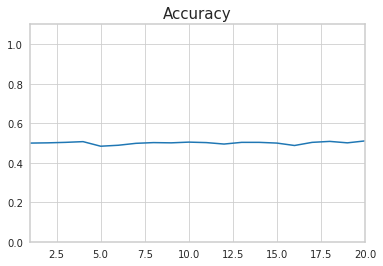

With mean accuracy= 0.4998778998778999


In [15]:
c = confounder(model=NeuralNetwork(32*32))
c.generate_data(mode="br-net", samples=512)
acc, loss = c.train(epochs=20, batch_size=96)
p = plot()
p.acc_loss(acc, loss)

t_SNE shape:  (1024, 2)


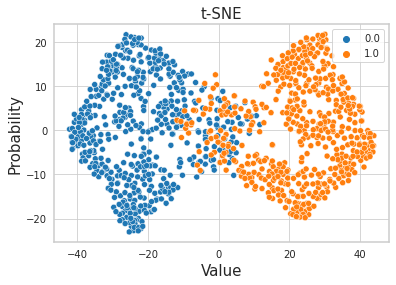

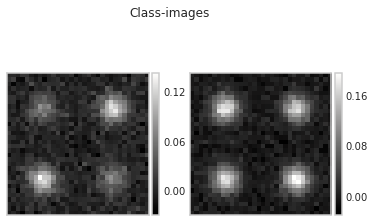

In [16]:
x = c.x
y = c.y
p = plot()
p.tsne(x, y, 2)
p.class_images(x)

### ConvNet

Training took  0.8625357151031494 s


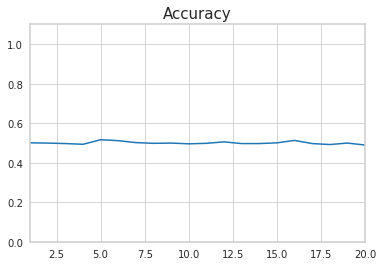

With mean accuracy= 0.5001221001221001


In [17]:
c = confounder(model=LeNet_5())
c.generate_data(mode="black_n_white", samples=512)
acc, loss = c.train(epochs=20, batch_size=96)
p.acc_loss(acc, loss)

t_SNE shape:  (1024, 2)


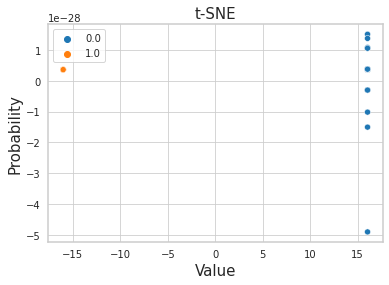

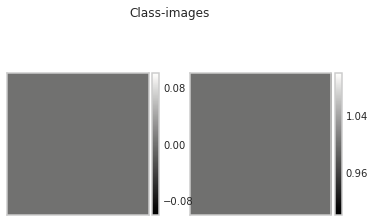

In [18]:
x = c.x
y = c.y
p = plot()
p.tsne(x, y, 2)
p.class_images(x)

### Br_Net

Training took  0.6391384601593018 s


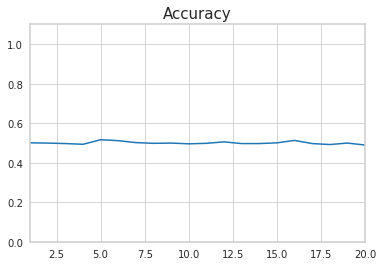

With mean accuracy= 0.5001221001221001


In [19]:
c = confounder(model=Br_Net())
c.generate_data(mode="br-net", samples=512)
acc, loss = c.train(epochs=20, batch_size=96)
p.acc_loss(acc, loss)

t_SNE shape:  (1024, 2)


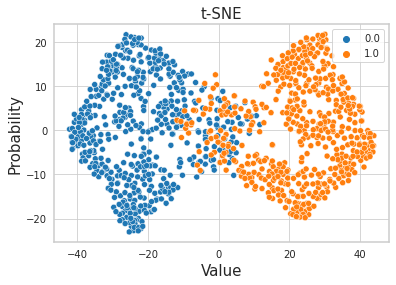

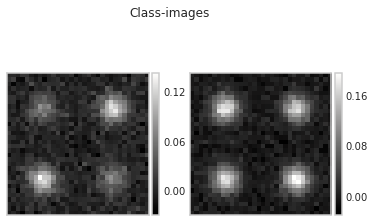

In [20]:
x = c.x
y = c.y
p = plot()
p.tsne(x, y, 2)
p.class_images(x)

In [21]:
c = create_dataloader(x,y,0.8,1)
data = c.get_dataloader()
for img, label in data[0]:
    print(img)
    print(label)

tensor([[[[-0.0120,  0.0030,  0.0060,  ...,  0.0209, -0.0379, -0.0023],
          [-0.0034,  0.0021,  0.0033,  ..., -0.0033,  0.0079,  0.0020],
          [-0.0120, -0.0095,  0.0106,  ...,  0.0051, -0.0071,  0.0009],
          ...,
          [ 0.0113, -0.0060,  0.0010,  ...,  0.0082, -0.0082,  0.0064],
          [ 0.0001, -0.0136, -0.0020,  ..., -0.0100,  0.0079, -0.0036],
          [-0.0126, -0.0063, -0.0066,  ...,  0.0083, -0.0082,  0.0017]]]])
tensor([0])
tensor([[[[ 7.5906e-03,  1.5366e-02,  3.4142e-03,  ...,  1.6059e-03,
           -6.1881e-03, -1.0955e-02],
          [-1.4022e-02,  9.6412e-03,  6.9439e-03,  ..., -4.4538e-03,
            6.5473e-03,  8.2336e-04],
          [-5.3971e-03, -4.4125e-03, -1.9644e-03,  ..., -1.6998e-02,
           -4.2833e-03,  2.5495e-03],
          ...,
          [-7.4117e-03, -7.9609e-03,  5.2724e-03,  ..., -2.9562e-03,
           -3.5894e-02,  1.0580e-03],
          [-8.7168e-03,  4.3759e-03, -1.7926e-02,  ..., -6.0946e-03,
           -8.2415e-03,  6